# Basic PINN

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import numpy as np
from common.pinn_base import BasePINN, PINNConfig
from common.trainer import PINNTrainer, TrainerConfig
from common.visualizer import PINNVisualizer
import matplotlib.pyplot as plt

In [2]:
class DiffusionPINN(BasePINN):
    def __init__(self, config):
        super().__init__(input_dim=2, output_dim=1, config=config)
        
    def compute_pde_residual(self, points):
        """Compute PDE residual for the heat equation"""
        # Asegurarnos de que points requiere gradiente
        if not points.requires_grad:
            points.requires_grad_(True)
            
        # Forward pass
        u = self.forward(points)
        
        # Primera derivada respecto al tiempo (componente 1)
        du_dt = torch.autograd.grad(
            u.sum(), points, 
            create_graph=True, 
            retain_graph=True
        )[0][:, 1:2]
        
        # Primera derivada respecto al espacio (componente 0)
        du_dx = torch.autograd.grad(
            u.sum(), points, 
            create_graph=True, 
            retain_graph=True
        )[0][:, 0:1]
        
        # Segunda derivada respecto al espacio
        d2u_dx2 = torch.autograd.grad(
            du_dx.sum(), points, 
            create_graph=True, 
            retain_graph=True
        )[0][:, 0:1]
        
        return du_dt - d2u_dx2

    def pde_residual_wrapper(self, points):
        return self.compute_pde_residual(points)

In [3]:
def generate_training_data(nx: int = 100, nt: int = 100) -> dict:
    """Generate training data for the diffusion equation"""
    # Domain points
    x = torch.linspace(0, 1, nx)
    t = torch.linspace(0, 1, nt)
    
    # Initial condition points
    x_init = torch.linspace(0, 1, nx).reshape(-1, 1)
    t_init = torch.zeros_like(x_init)
    u_init = torch.sin(np.pi * x_init)
    
    # Boundary condition points
    t_bound = torch.linspace(0, 1, nt).reshape(-1, 1)
    x_bound_left = torch.zeros_like(t_bound)
    x_bound_right = torch.ones_like(t_bound)
    u_bound = torch.zeros_like(t_bound)
    
    # Collocation points for residual
    x_resid = torch.rand(1000, 1)
    t_resid = torch.rand(1000, 1)
    
    # Combine boundary points
    x_bound = torch.cat([x_bound_left, x_bound_right])
    t_bound = torch.cat([t_bound, t_bound])
    u_bound = torch.cat([u_bound, u_bound])
    
    return {
        'x': x,
        't': t,
        'x_init': x_init,
        't_init': t_init,
        'u_init': u_init,
        'x_bound': x_bound,
        't_bound': t_bound,
        'u_bound': u_bound,
        'x_resid': x_resid,
        't_resid': t_resid
    }

In [4]:
def exact_solution(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute exact solution for comparison"""
    k = 0.1  # Diffusion coefficient
    return torch.sin(np.pi * x) * torch.exp(-k * (np.pi**2) * t)

In [5]:
# Configuration
pinn_config = PINNConfig(
    hidden_layers=4,
    neurons_per_layer=50,
    activation=torch.nn.Tanh(),
    w_initial=1.0,
    w_boundary=1.0,
    w_residual=1.0
)

trainer_config = TrainerConfig(
    adam_iterations=5000,
    initial_lr=1e-3,
    resampling_enabled=True
)

In [6]:
# Generate data
data = generate_training_data()

In [7]:
# Initialize model and trainer
model = DiffusionPINN(pinn_config)
trainer = PINNTrainer(model, trainer_config)
visualizer = PINNVisualizer()

In [8]:
# Training points
x_init_t = torch.cat([data['x_init'], data['t_init']], dim=1)
x_bound_t = torch.cat([data['x_bound'], data['t_bound']], dim=1)
x_resid_t = torch.cat([data['x_resid'], data['t_resid']], dim=1)

In [9]:
# Domain bounds for resampling
domain_bounds = torch.tensor([[0., 1.], [0., 1.]])

In [10]:
# Generate test points for full solution visualization
x_test = data['x'].reshape(-1, 1)
t_test = data['t'].reshape(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
test_points = torch.stack([X.flatten(), T.flatten()], dim=1)

c:\Users\mated\anaconda3\envs\torch_win39\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
# Compute exact solution
u_exact = exact_solution(X, T)

In [12]:
# Train model
print("Starting training...")
history = trainer.train(
    x_init_t, data['u_init'],
    x_bound_t, data['u_bound'],
    x_resid_t, domain_bounds,
    model.pde_residual_wrapper,
    test_points, 
    u_exact.flatten().reshape(-1, 1)
)

Starting training...
Starting Adam optimization phase...
Step 0: Loss = 0.616918
Step 100: Loss = 0.122632
Step 200: Loss = 0.043912
Step 300: Loss = 0.009649
Step 400: Loss = 0.004989
Step 500: Loss = 0.003504
Step 600: Loss = 0.001156
Step 700: Loss = 0.000738
Step 800: Loss = 0.000922
Step 900: Loss = 0.002307
Step 1000: Loss = 0.003078
Step 1100: Loss = 0.000337
Step 1200: Loss = 0.000264
Step 1300: Loss = 0.000224
Step 1400: Loss = 0.000302
Step 1500: Loss = 0.000181
Step 1600: Loss = 0.000233
Step 1700: Loss = 0.000216
Step 1800: Loss = 0.000302
Step 1900: Loss = 0.000208
Step 2000: Loss = 0.000214
Step 2100: Loss = 0.000184
Step 2200: Loss = 0.000146
Step 2300: Loss = 0.000129
Step 2400: Loss = 0.000225
Step 2500: Loss = 0.000159
Step 2600: Loss = 0.000142
Step 2700: Loss = 0.000126
Step 2800: Loss = 0.000127
Step 2900: Loss = 0.000112
Step 3000: Loss = 0.000098
Step 3100: Loss = 0.000088
Step 3200: Loss = 0.000086
Step 3300: Loss = 0.000078
Step 3400: Loss = 0.000123
Step 3500:

In [13]:
# Evaluate predictions
model.eval()
with torch.no_grad():
    u_pred = model(test_points).reshape(X.shape)

In [14]:
# Compute error
error = torch.abs(u_pred - u_exact)


Generating visualizations...


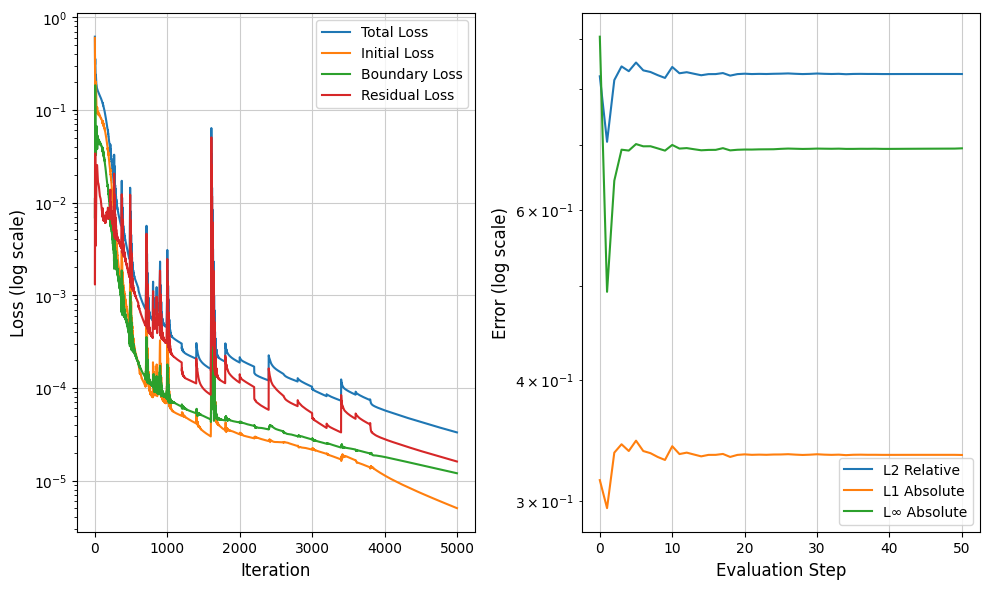

In [15]:
# Visualizations
print("\nGenerating visualizations...")

# Plot training history
visualizer.plot_training_history(history, "training_history.png")

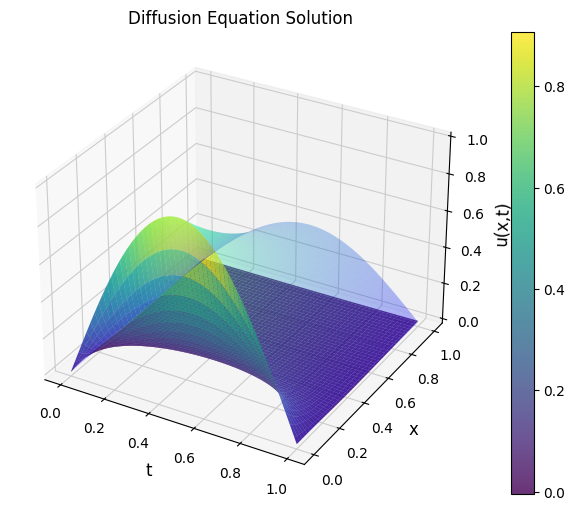

In [16]:
# Plot solution comparison
visualizer.plot_1d_solution(
    data['t'], data['x'],
    u_pred, u_exact,
    "Diffusion Equation Solution",
    "solution_comparison.png"
)

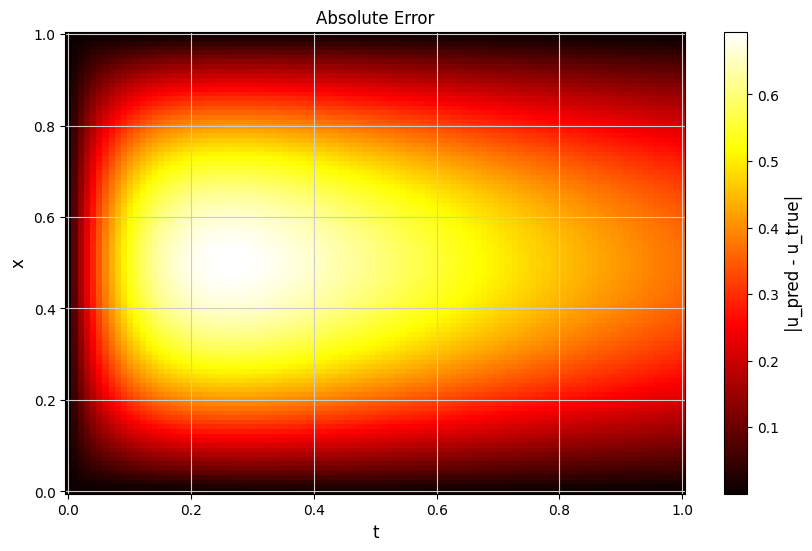

In [17]:
# Plot error heatmap
visualizer.plot_error_heatmap(
    error, data['x'], data['t'],
    "Absolute Error",
    "error_heatmap.png"
)

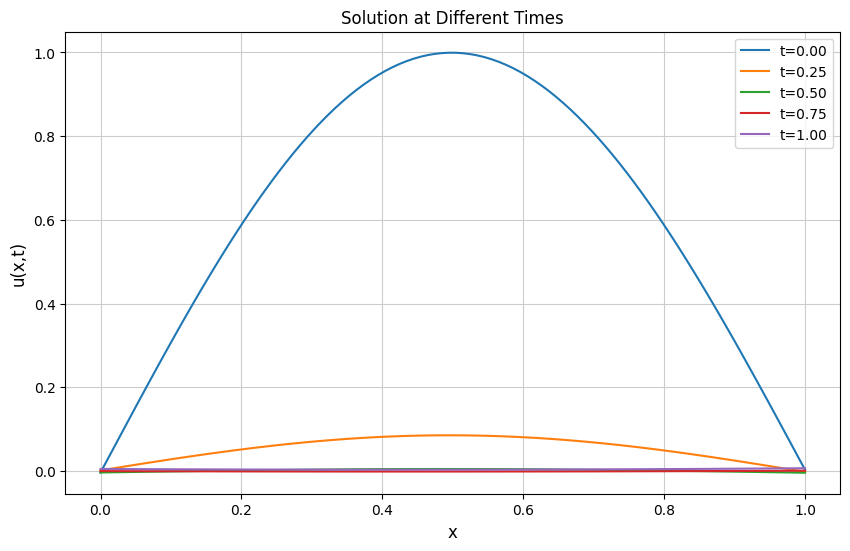

In [18]:
# Plot solutions at specific times
times = [0.0, 0.25, 0.5, 0.75, 1.0]
visualizer.plot_multiple_times(
    data['x'], data['t'], u_pred,
    times,
    "Solution at Different Times",
    "solution_times.png"
)

In [19]:
print("\nExperiment completed!")


Experiment completed!
